In [1]:
working_dir = "/data/projects/dschaub/ANCA-GN_transcriptomics"
data_dir = "data/single-cell/exploratory/alignment"
save_dir = "data/single-cell/exploratory/prefiltering_objects"

In [2]:
setwd(working_dir)

library(Seurat)
library(dplyr)
#library(tidyverse)
library(here)
#library(readxl)
#library(future)
#library(Matrix)
library(Signac)
library(ggplot2)
library(IMSBSeuratHelpers)

Attaching SeuratObject


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


here() starts at /data/projects/dschaub/ANCA-GN_transcriptomics



In [3]:
sample_ID<-"E026"

In [4]:
path = file.path(data_dir, sample_ID)
print(path)
seu.data <- Read10X(data.dir = path)
#dim(seu.data)
seu.rna<-seu.data$`Gene Expression`
seu.adt<-seu.data$`Antibody Capture`
dim(seu.rna)
dim(seu.adt)

[1] "data/single-cell/exploratory/alignment/E026"


10X data contains more than one type and is being returned as a list containing matrices of each type.



[1] 36601  5812

[1]   41 5812

In [5]:
rownames(seu.adt) <- sub("_TotalSeqC", "", rownames(seu.adt))

In [6]:
seu <- CreateSeuratObject(counts = seu.rna,
                          min.cells = 0, 
                          min.features = 0, project=sample_ID)
seu


An object of class Seurat 
36601 features across 5812 samples within 1 assay 
Active assay: RNA (36601 features, 0 variable features)

In [7]:
seu[["CITE"]] <- CreateAssayObject(counts = seu.adt)
seu

An object of class Seurat 
36642 features across 5812 samples within 2 assays 
Active assay: RNA (36601 features, 0 variable features)
 1 other assay present: CITE

In [8]:
seu <- count_fractions(seu,species = "human")

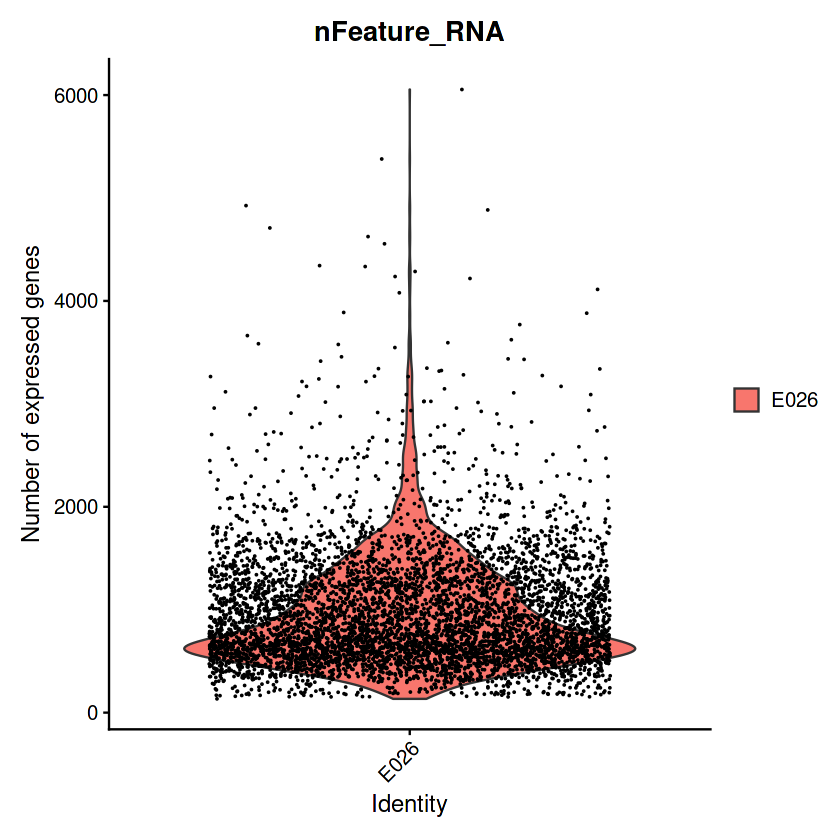

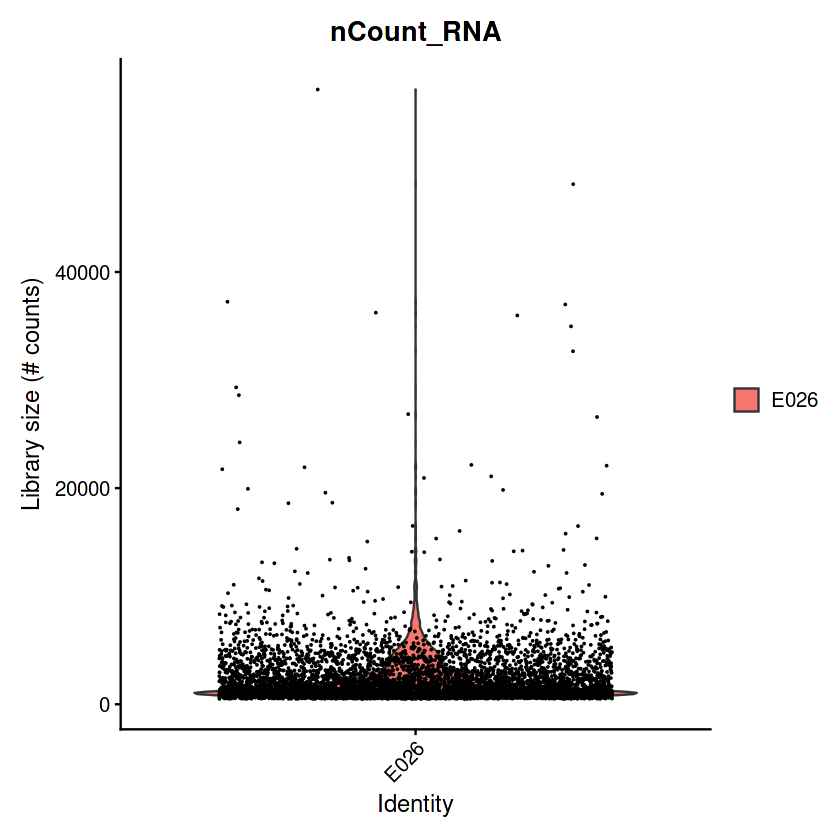

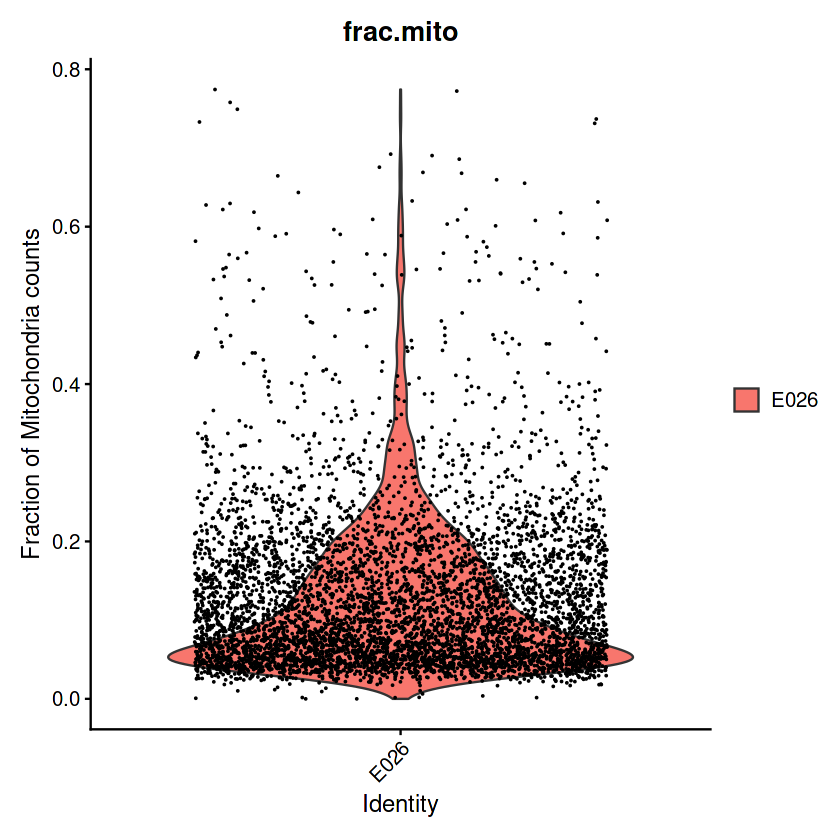

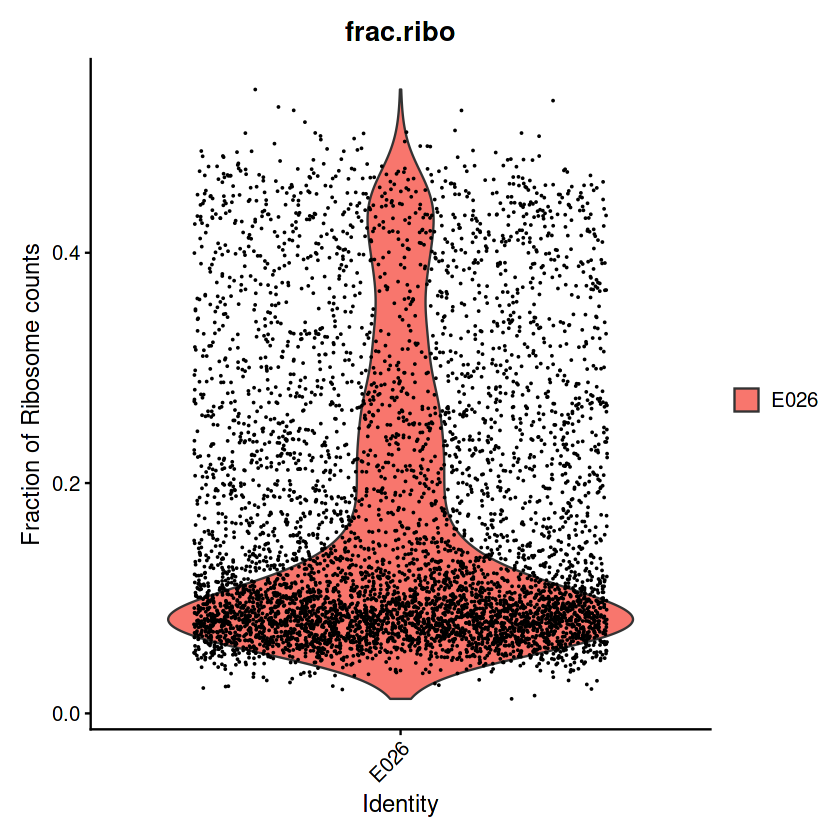

$number_of_genes

$number_of_counts

$frac.mito

$frac.ribo

$num_counts_vs_frac.mito

$num_counts_vs_num_genes


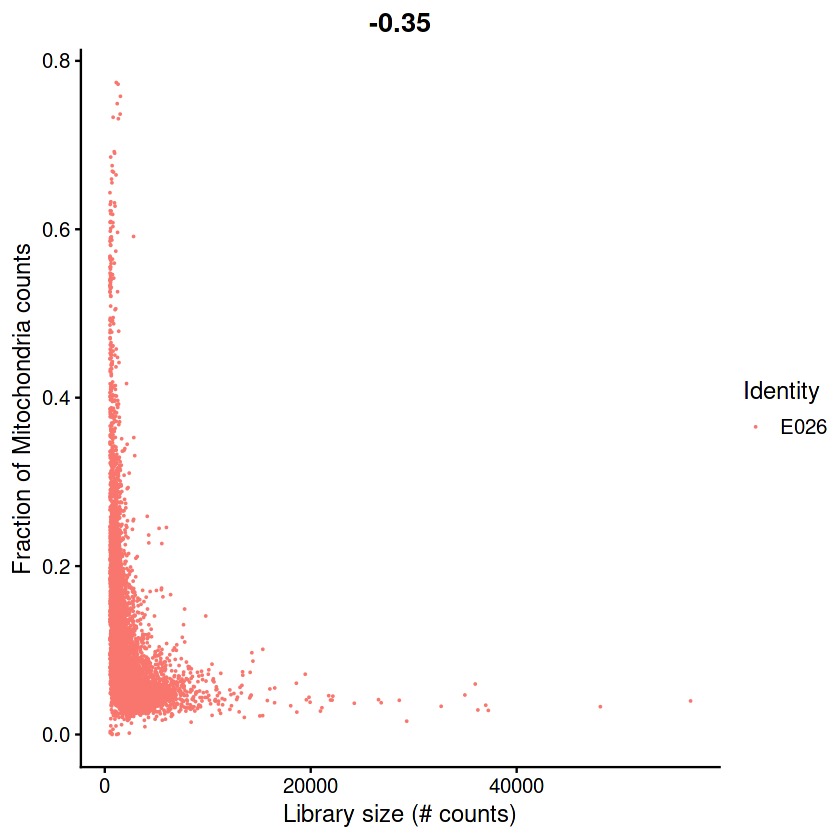

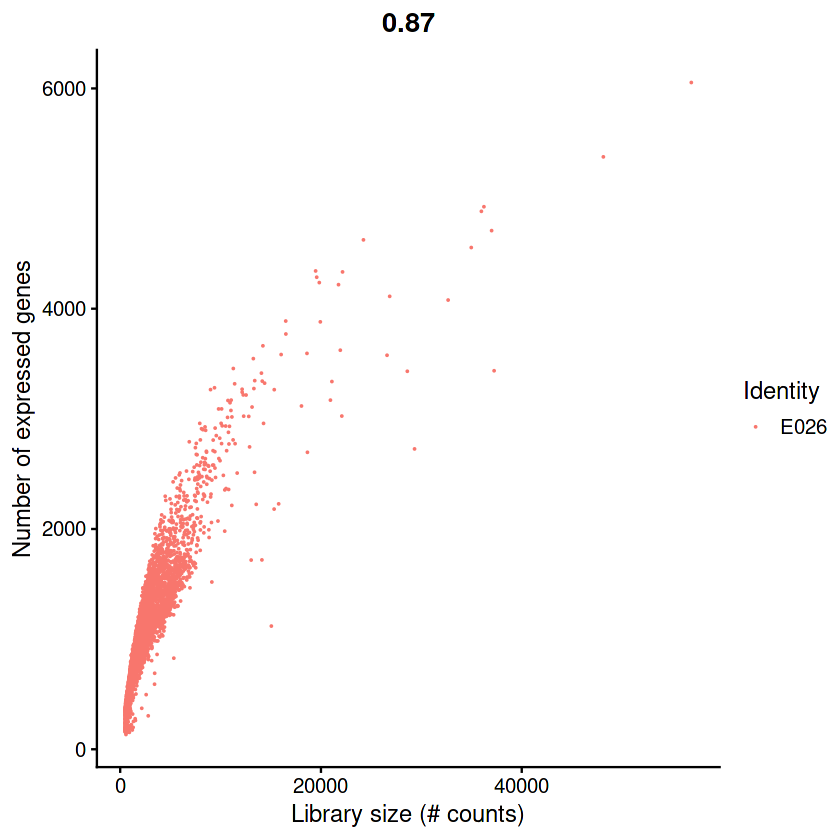

In [9]:
#qc plot before filtering
suppressWarnings(plt<-plot_mito_ribo(seu))
plt

In [10]:
seu@meta.data$Feature_Count_ratio<-
seu@meta.data$nFeature_RNA/seu@meta.data$nCount_RNA
head(seu@meta.data)

,orig.ident,nCount_RNA,nFeature_RNA,nCount_CITE,nFeature_CITE,frac.mito,frac.ribo,Feature_Count_ratio
,<fct>,<dbl>,<int>,<dbl>,<int>,<dbl>,<dbl>,<dbl>
AAACCTGAGCCCAACC-1,E026,560,355,1022,24,0.13750000,0.1339286,0.6339286
AAACCTGCACGAGGTA-1,E026,5642,2177,2573,24,0.05494505,0.2254520,0.3858561
AAACCTGCACTCGACG-1,E026,2451,891,1498,26,0.03875969,0.4222766,0.3635251
AAACCTGCAGATGAGC-1,E026,2235,1067,815,27,0.03400447,0.2827740,0.4774049
AAACCTGCATAAAGGT-1,E026,570,379,559,22,0.17719298,0.1140351,0.6649123
AAACCTGGTACTCTCC-1,E026,8404,2605,10078,28,0.07805807,0.2718943,0.3099714


In [11]:
#filtering cells
frac_mito_threshold <- 0.1
min_num_genes <- 500
max_num_genes <- 5000
seu <- subset(seu,
             frac.mito < frac_mito_threshold &
             nFeature_RNA > min_num_genes &
             nFeature_RNA < max_num_genes
             )
seu

An object of class Seurat 
36642 features across 2843 samples within 2 assays 
Active assay: RNA (36601 features, 0 variable features)
 1 other assay present: CITE

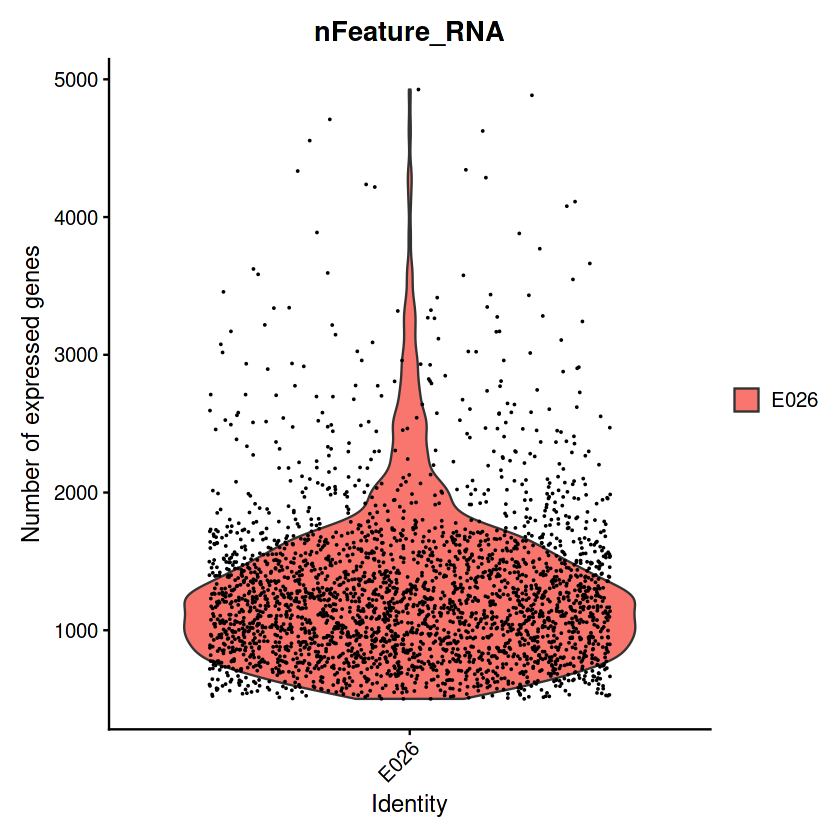

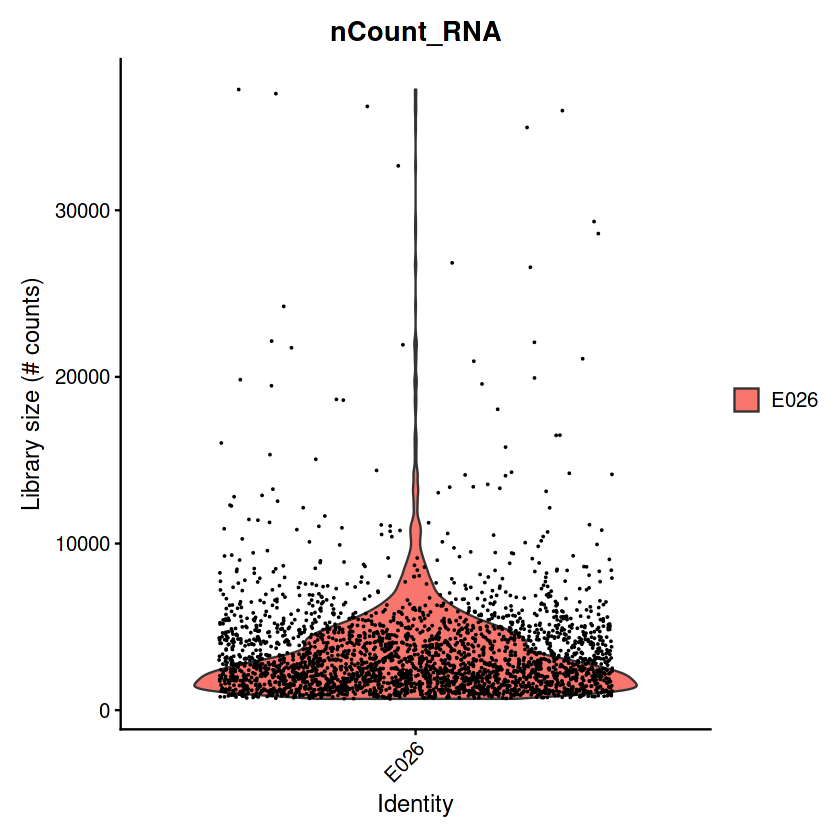

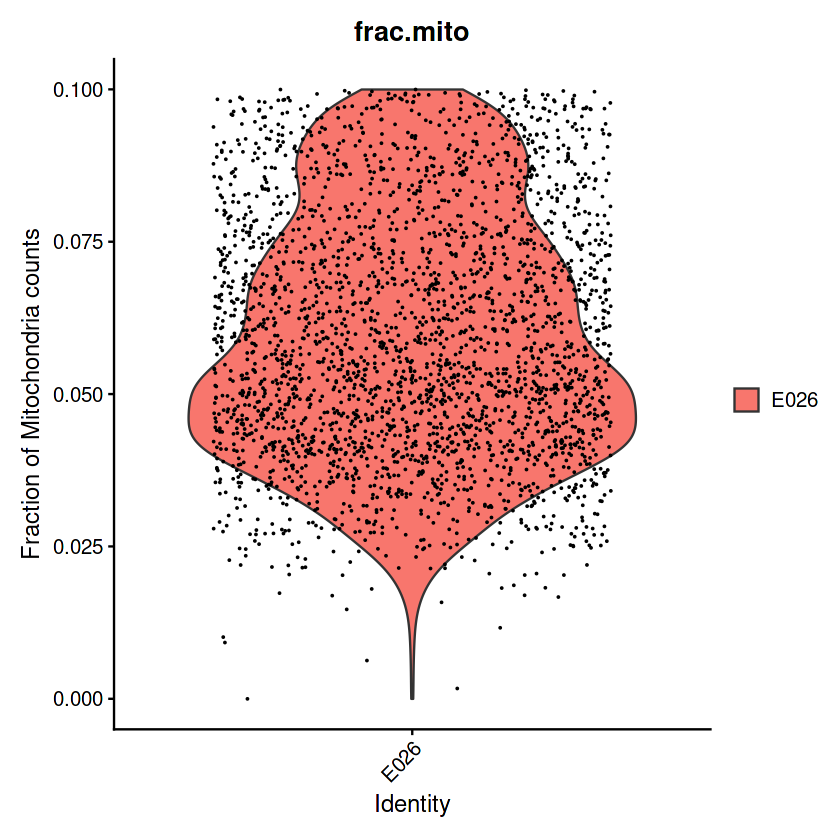

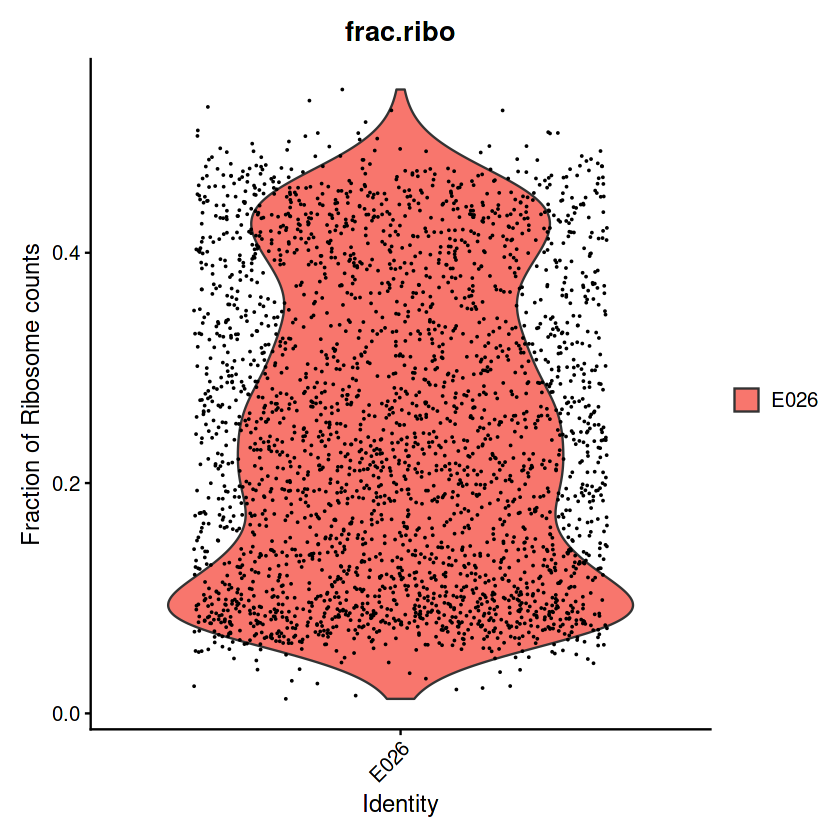

$number_of_genes

$number_of_counts

$frac.mito

$frac.ribo

$num_counts_vs_frac.mito

$num_counts_vs_num_genes


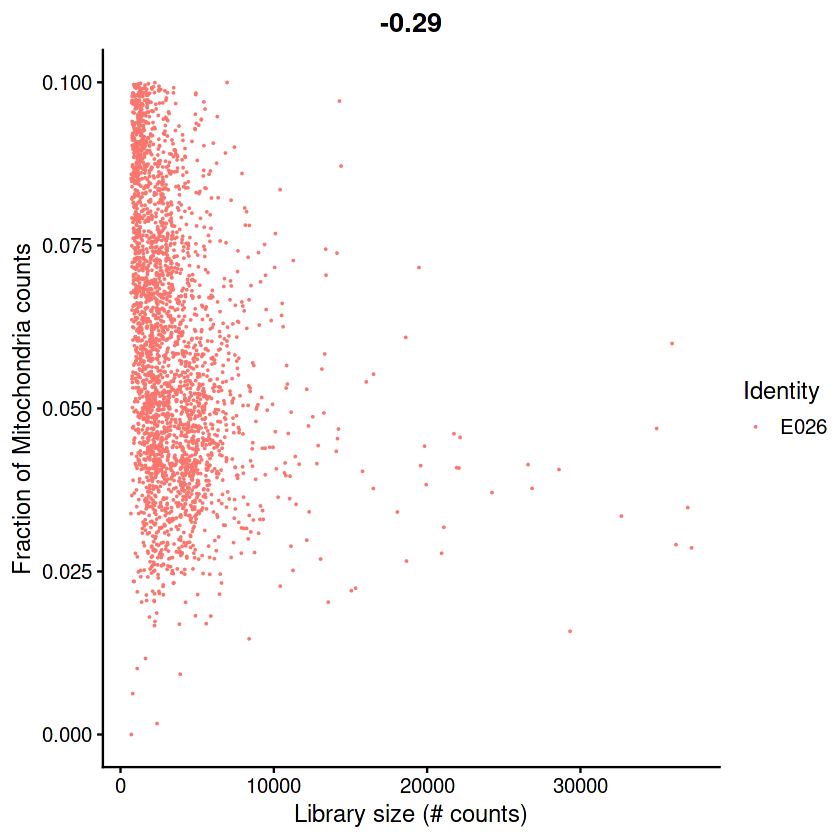

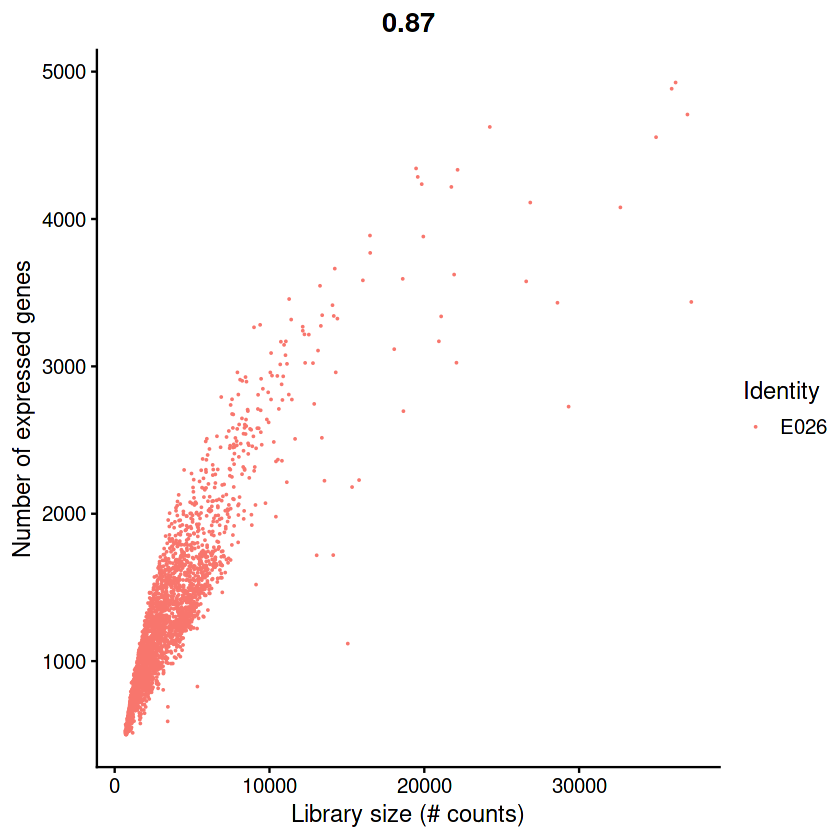

In [12]:
#qc plot after filtering
suppressWarnings(plt<-plot_mito_ribo(seu))
plt

In [13]:
seu

An object of class Seurat 
36642 features across 2843 samples within 2 assays 
Active assay: RNA (36601 features, 0 variable features)
 1 other assay present: CITE

In [14]:
CD3_genes<-c("CD3D","CD3E","CD3G")
CD3_count<- Matrix::colSums(GetAssayData(
    object = seu, slot = 'counts')[CD3_genes,])
head(CD3_count)
table(CD3_count)
length(CD3_count)
seu[['CD3_count']]<-CD3_count
#seu <- AddMetaData(object = seu, metadata = CD3_count, col.name = "CD3_count")
dim(seu@meta.data)

AAACCTGCACGAGGTA-1 AAACCTGCACTCGACG-1 AAACCTGCAGATGAGC-1 AAACCTGGTACTCTCC-1 
                 5                  5                  0                 18 
AAACCTGGTAGCTAAA-1 AAACCTGGTCCGAATT-1 
                18                  0

CD3_count
  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18  19 
466 295 223 225 171 145 173 165 166 139 118 116  87  64  49  47  25  26  21  17 
 20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  37  39  40  41  44 
 14  12   6   7   6   9   3   2   5   8   5   2   2   1   4   3   2   3   1   1 
 45  48  50  52  54  58  63  65 
  1   2   1   1   1   1   1   1 

[1] 2843

[1] 2843    9

In [15]:
dim(seu@assays$CITE@counts)
seu@assays$CITE@counts[,1:10]

[1]   41 2843

   [[ suppressing 10 column names ‘AAACCTGCACGAGGTA-1’, ‘AAACCTGCACTCGACG-1’, ‘AAACCTGCAGATGAGC-1’ ... ]]



41 x 10 sparse Matrix of class "dgCMatrix"
                                                       
PDL1          .   1   .    2    2   .   1    .    1   .
CD154         7   5   4   25   48   4   .    1   14  32
CD3         130  73  10  222  257   6  73    8   16 142
CD4         227 219  12  371  206  13 296    4   21  26
CD8           6   8   7   31   51   .   3    .    9  31
CD56          .   .   .    1    1   1   2    .    .   3
CD45        159 112  68  252  240  71  84   75   85 139
CD19          .   .   .    .    .   .   .    .    .   .
CD14          .   .   .    .    .   .   .    .    .   .
HLAABC        .   .   .    .    .   .   .    .    .   .
CD45RA       82   3   3  113   21   2   1   25   89  72
CD7           .   .   .    .    .   .   .    .    .   .
CD49f         .   .   .    .    .   .   .    .    .   .
CD25         18  17  24   56  104  12   6    3   21  55
CD45RO       11  15  11   48   67   4   1    .    7  16
TIGIT         2   .   .    .    .   .   .    .    .   5
EpCAM

In [16]:
save_path = file.path(save_dir, paste0(sample_ID,".rds"))
save_path

[1] "data/single-cell/exploratory/prefiltering_objects/E026.rds"

In [17]:
saveRDS(seu, file = save_path)